In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from model_distances import distance_matrix
from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import LeNet5
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Hyperparameters

In [4]:
RERUN = False

In [5]:
EXPERIMENT_PATH = Path.cwd() / 'results' / 'hr_analysis_cifar10_lenet'

if not EXPERIMENT_PATH.is_dir():
    os.makedirs(EXPERIMENT_PATH)

In [6]:
# Test set corresponding to the data used to train the model zoo
TESTSET_DS = torch.load('/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_lenet/dataset.pt')['testset']
TESTSET_DL = torch.utils.data.DataLoader(TESTSET_DS, batch_size=64, shuffle=False)

# Model zoo
ZOO_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/cifar10_train_zoo_lenet')
ZOO_DS = torch.load(ZOO_PATH / 'dataset_test.pt')
ZOO_DL = torch.utils.data.DataLoader(ZOO_DS, batch_size=16, shuffle=False)

ZOO_DS_TRAIN = torch.load(ZOO_PATH / 'dataset_train.pt')
ZOO_DL_TRAIN = torch.utils.data.DataLoader(ZOO_DS_TRAIN, batch_size=16, shuffle=False)

# Threshold used to define models that "perform well"; depends on the zoo
MODEL_ACC_THR = 0.6

# Path to the hyper-representation models
HYPERREP_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune/cifar10_train_hyperrep_lenet')

## Loading data

### Loading HR models meta-data

In [7]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for path in os.listdir(HYPERREP_PATH):
    if not re.match('AE_trainable', path):
        continue
    path = HYPERREP_PATH / path
    
    with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
        config = json.load(ifh_config)
        result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})
    
    for edx in range(len(result)):
        df_hr.loc[len(df_hr)] = (
            result.loc[edx]['trial_id'],
            config['optim::lr'],
            config['ae:lat_dim'],
            config['training::loss_distillation'],
            config['training::queryset_distillation'],
            config['training::queryset_dump'],
            config['training::n_queries_distillation'],
            config['training::gamma'],
            config['training::beta'],
            result.loc[edx]['training_iteration'],
            result.loc[edx]['loss/loss_train'],
            result.loc[edx]['loss/loss_contrast_train'],
            result.loc[edx]['loss/loss_recon_train'],
            result.loc[edx]['loss/loss_structure_train'],
            result.loc[edx]['loss/loss_behaviour_train'],
            result.loc[edx]['loss/loss_test'],
            result.loc[edx]['loss/loss_contrast_test'],
            result.loc[edx]['loss/loss_recon_test'],
            result.loc[edx]['loss/loss_structure_test'],
            result.loc[edx]['loss/loss_behaviour_test'],
            result.loc[edx]['dstk/test_acc_test'],
            result.loc[edx]['dstk/ggap_test']
        )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_lenet/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet-32'
})
df_hr.head()

,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,Epoch,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,ad4d1_00001,0.00001,64,l2,data,CIFAR-10,256,0.05,0.1,0,...,1.014984,0.965136,1.020523,0.987910,1.051444,0.984566,0.878355,0.996367,0.613698,0.390561
1,ad4d1_00001,0.00001,64,l2,data,CIFAR-10,256,0.05,0.1,1,...,0.365454,0.616075,0.337607,0.354617,0.636116,0.339801,0.542446,0.317285,0.620943,0.387704
2,ad4d1_00001,0.00001,64,l2,data,CIFAR-10,256,0.05,0.1,2,...,0.365129,0.602794,0.338721,0.349775,0.652141,0.333861,0.499569,0.315449,0.651046,0.433953
3,ad4d1_00001,0.00001,64,l2,data,CIFAR-10,256,0.05,0.1,3,...,0.365217,0.608900,0.338141,0.348739,0.565116,0.337350,0.520044,0.317051,0.673200,0.471973
4,ad4d1_00001,0.00001,64,l2,data,CIFAR-10,256,0.05,0.1,4,...,0.363532,0.597779,0.337505,0.345205,0.600630,0.331762,0.478027,0.315510,0.693332,0.506059


### Loading checkpoints

In [8]:
# Loading hyper-reps
def load_hr(trial_id):
    for path in os.listdir(HYPERREP_PATH):
        if trial_id in path:
            model_path = HYPERREP_PATH / path
    return load_hyperrep_edx(model_path, MAX_EPOCH)

hyper_reps = {idx: load_hr(idx) for idx in df_hr['Trial ID'].unique()}

In [9]:
# Loading reference config
trial_id = df_hr.iloc[0]['Trial ID']
for path in os.listdir(HYPERREP_PATH):
    if trial_id in path:
        model_path = HYPERREP_PATH / path
        with open(HYPERREP_PATH / path / 'params.json') as ifh:
            ref_config = json.load(ifh)

# Loading reference params
ref_path = ref_config["training::distil_reference"]
with open(os.path.join(ref_path, 'params.json')) as ifh:
    reference_params = json.load(ifh)
    
# Loading reference checkpoint
ref_chkpth = None
for chkpth in os.listdir(ref_path):
    if 'checkpoint_' in chkpth:
        if not ref_chkpth or int(chkpth.split('_')[-1]) > int(ref_chkpth.split('_')[-1]):
            ref_chkpth = chkpth

reference_checkpoint = torch.load(Path(ref_path) / str(ref_chkpth) / 'checkpoints', map_location=torch.device("cpu"))
reference_checkpoint_cuda = {k: v.to('cuda') for k, v in deepcopy(reference_checkpoint).items()}

reference_model = LeNet5(
    channels_in=reference_params['model::channels_in'],
    nlin=reference_params['model::nlin'],
    dropout=reference_params['model::dropout']
)
f"Number of parameters: {sum(p.numel() for p in reference_model.parameters())}"

'Number of parameters: 62006'

## Analysing the zoo

In [10]:
DF_ZOO_PATH = EXPERIMENT_PATH / 'df_zoo.csv'

if not DF_ZOO_PATH.is_file() or RERUN:
    df_zoo = pd.DataFrame(columns=[
        'Trial ID',
        'Activation function',
        'Initialisation',
        'Learning rate',
        'Weight decay',
        'Seed',
        'Epoch',
        'Test accuracy',
        'Generalisation gap'
    ])

    for path in os.listdir(ZOO_PATH):
        if not re.match('NN_tune', path):
            continue
        path = ZOO_PATH / path

        with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
            config = json.load(ifh_config)
            result = pd.read_json(ifh_result, lines=True)

        for edx in range(len(result)):
            df_zoo.loc[len(df_zoo)] = (
                result.loc[edx]['trial_id'],
                config['model::nlin'],
                config['model::init_type'],
                config['optim::lr'],
                config['optim::wd'],
                config['seed'],
                result.loc[edx]['training_iteration'],
                result.loc[edx]['test_acc'],
                result.loc[edx]['train_acc'] - result.loc[edx]['test_acc']
            )

    df_zoo.to_csv(DF_ZOO_PATH)

df_zoo = pd.read_csv(DF_ZOO_PATH, index_col=0)
df_zoo.head()

,Trial ID,Activation function,Initialisation,Learning rate,Weight decay,Seed,Epoch,Test accuracy,Generalisation gap
0,3d79b_00481,relu,normal,0.0001,0.0001,8,0,0.0977,0.001789
1,3d79b_00481,relu,normal,0.0001,0.0001,8,1,0.1407,-0.018144
2,3d79b_00481,relu,normal,0.0001,0.0001,8,2,0.1514,-0.002800
3,3d79b_00481,relu,normal,0.0001,0.0001,8,3,0.1616,-0.002756
4,3d79b_00481,relu,normal,0.0001,0.0001,8,4,0.1692,-0.001533


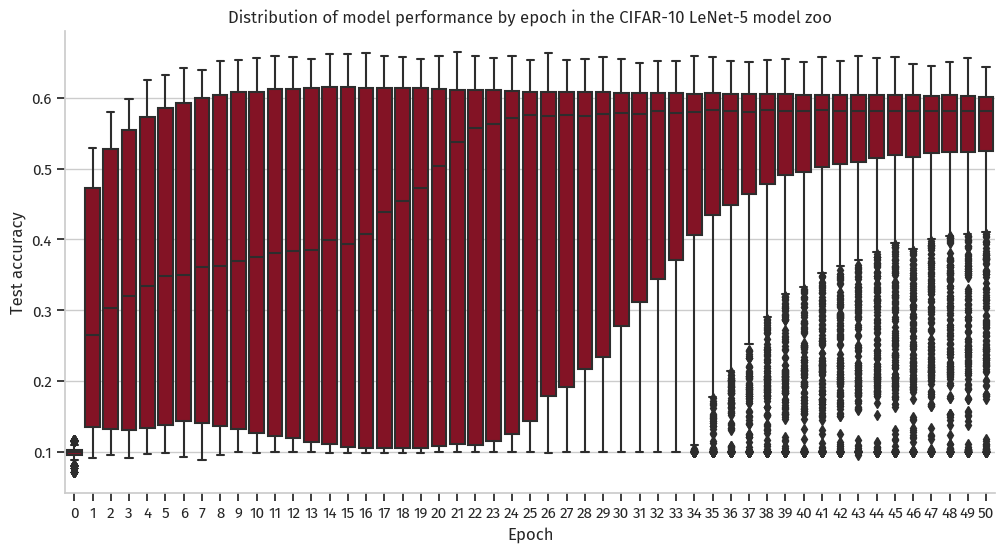

In [11]:
_, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(df_zoo, x='Epoch', y='Test accuracy', color=COLOURS[0], ax=ax).set(
    title=f'Distribution of model performance by epoch in the CIFAR-10 LeNet-5 model zoo'
)

plt.show()

## Analysing the training loss

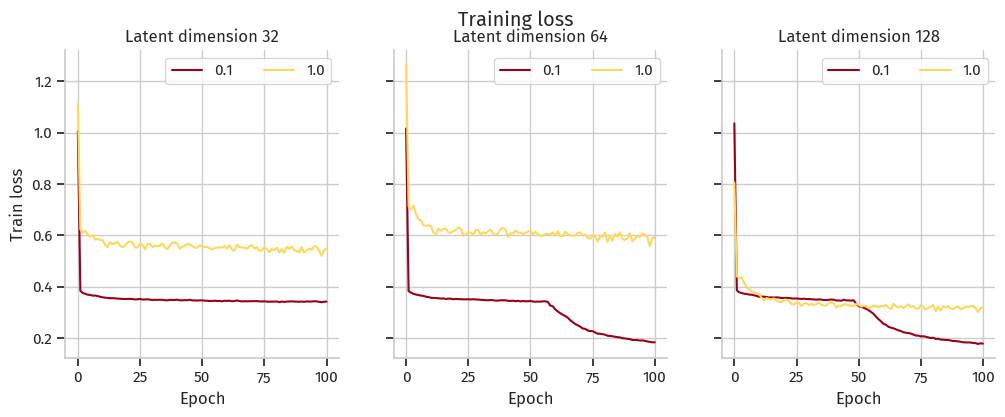

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

sns.lineplot(df_hr[(df_hr['Latent dimension'] == 32)], x='Epoch', y='Train loss', hue='Beta', palette=COLOURS[:2], ax=axs[0]).set(
    title='Latent dimension 32'
)

sns.lineplot(df_hr[(df_hr['Latent dimension'] == 64)], x='Epoch', y='Train loss', hue='Beta', palette=COLOURS[:2], ax=axs[1]).set(
    title='Latent dimension 64'
)

sns.lineplot(df_hr[(df_hr['Latent dimension'] == 128)], x='Epoch', y='Train loss', hue='Beta', palette=COLOURS[:2], ax=axs[2]).set(
    title='Latent dimension 128'
)

for ax in axs.flatten():
    ax.legend(ncol=2)

plt.suptitle('Training loss')
plt.show()

### Extracting key models

In [13]:
df_hr[(df_hr['Epoch'] == MAX_EPOCH)]

,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,Epoch,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
100,ad4d1_00001,0.00001,64,l2,data,CIFAR-10,256,0.05,0.1,100,...,0.187583,0.551708,0.147125,0.168699,0.257781,0.164011,0.444819,0.132810,0.874009,0.793088
201,ad4d1_00002,0.00001,128,l2,data,CIFAR-10,256,0.05,0.1,100,...,0.182040,0.511219,0.145464,0.163550,0.268079,0.158048,0.411407,0.129897,0.903350,0.818749
302,ad4d1_00004,0.00001,64,l2,data,CIFAR-10,256,0.05,1.0,100,...,0.618810,0.618810,0.000000,0.474168,0.257931,0.485549,0.485549,0.000000,0.771340,0.680193
403,ad4d1_00005,0.00001,128,l2,data,CIFAR-10,256,0.05,1.0,100,...,0.331971,0.331971,0.000000,0.253497,0.246224,0.253880,0.253880,0.000000,0.751374,0.703460
504,ad4d1_00003,0.00001,32,l2,data,CIFAR-10,256,0.05,1.0,100,...,0.571498,0.571498,0.000000,0.438542,0.243456,0.448809,0.448809,0.000000,0.718191,0.663882
605,ad4d1_00000,0.00001,32,l2,data,CIFAR-10,256,0.05,0.1,100,...,0.355268,0.537208,0.335052,0.318632,0.250425,0.322222,0.419151,0.311452,0.722061,0.635785


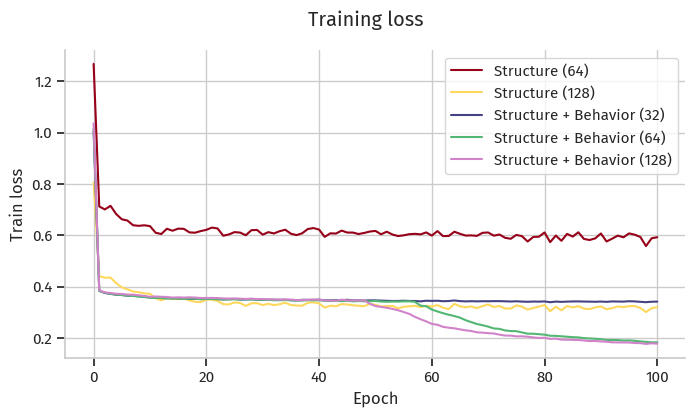

In [14]:
idx_dict = {
    'ad4d1_00004': 'Structure (64)',
    'ad4d1_00005': 'Structure (128)',
    'ad4d1_00000': 'Structure + Behavior (32)',
    'ad4d1_00001': 'Structure + Behavior (64)',
    'ad4d1_00002': 'Structure + Behavior (128)'
}
idx_ref_chk = list(idx_dict.keys())[0]
f"Reference checkpoint: {idx_ref_chk}"


_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Train loss', color=COLOURS[i], label=label, ax=ax)
    
plt.legend()
plt.suptitle('Training loss')
plt.show()

## Analysing discriminative downstream tasks

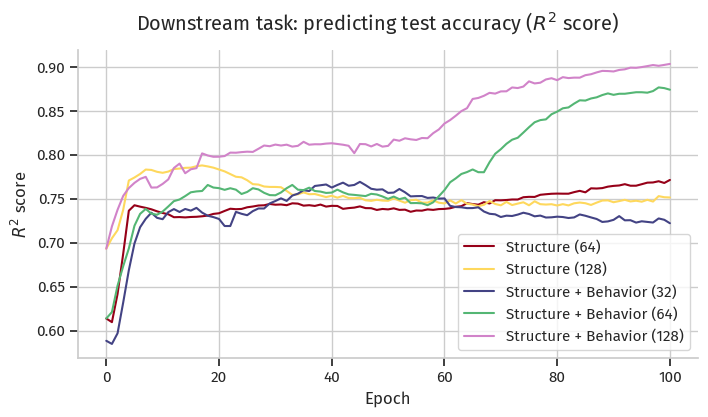

In [15]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: Test accuracy', color=COLOURS[i], label=label, ax=ax)
    
ax.set(ylabel='$R^2$ score')
    
plt.legend()
plt.suptitle('Downstream task: predicting test accuracy ($R^2$ score)')
plt.show()

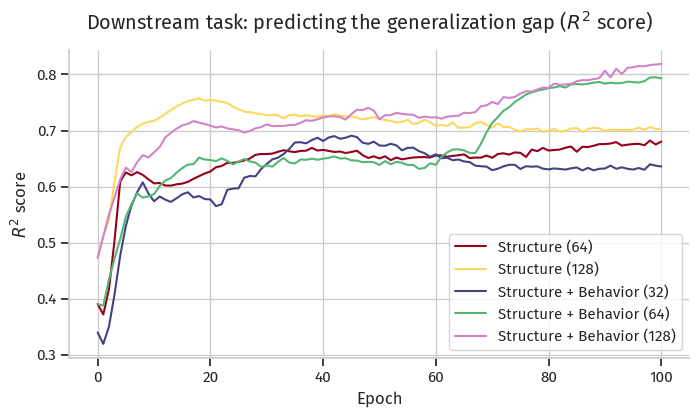

In [16]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.lineplot(df_hr[df_hr['Trial ID'] == idx], x='Epoch', y='Dstk: GGap', color=COLOURS[i], label=label, ax=ax)
    
ax.set(ylabel='$R^2$ score')
    
plt.legend()
plt.suptitle('Downstream task: predicting the generalization gap ($R^2$ score)')
plt.show()

## Analysing reconstruction

In [17]:
def compute_reconstruction_acc(hr, x, p, i, dataloader):
    z, y, zp = hr.forward(x, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint)
    model = LeNet5(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return test_model(model, dataloader, device='cuda')

### Distribution of reconstructed accuracies

In [18]:
DF_ZOO_ACC_PATH = EXPERIMENT_PATH / 'df_zoo_acc.csv'
DF_Z_PATH = EXPERIMENT_PATH / 'df_z_dict.csv'
DF_X_PATH = EXPERIMENT_PATH / 'df_x_dict.csv'

X_DIM_1, X_DIM_2 = next(iter(ZOO_DL))[0].shape[1:3]
X_COLS = [f'Dimension {i}' for i in range(X_DIM_1 * X_DIM_2)]

Z_DIM_1 = X_DIM_1
Z_DIM_2 = 128
Z_COLS = [f'Dimension {i}' for i in range(Z_DIM_1 * Z_DIM_2)]

if not DF_ZOO_ACC_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_acc = pd.DataFrame(columns=['Model index', 'Hyper-representation model', 'Original accuracy', 'Reconstruction accuracy'])
    df_x = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + X_COLS)
    df_z = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + Z_COLS)

    # Run experiments
    for bdx, data in enumerate(tqdm(ZOO_DL)):
        x, m, p, _ = data

        for hr_idx, hr_label in idx_dict.items():
            z, y, _ = hyper_reps[hr_idx].forward(x, p)
            
            for idx in range(x.shape[0]):
                # Original accuracy
                orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
                orig_model = LeNet5(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                orig_model.load_state_dict(orig_checkpoint)
                orig_acc = test_model(orig_model, TESTSET_DL)
                
                # Reconstruction accuracy
                recon_checkpoint = tokens_to_checkpoint(y[idx], p[idx], reference_checkpoint)
                recon_model = LeNet5(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                recon_model.load_state_dict(recon_checkpoint)
                recon_acc = test_model(recon_model, TESTSET_DL)
                
                # Save results to DataFrame
                mdx = bdx * x.shape[0] + idx
                df_zoo_acc.loc[len(df_zoo_acc)] = (
                    mdx,
                    hr_label,
                    orig_acc,
                    recon_acc
                )
                df_x.loc[len(df_x)] = [mdx, hr_label] + x[idx].flatten().tolist()
                
                z_sample = z[idx].flatten().tolist()
                z_sample = z_sample if len(z_sample) == len(Z_COLS) else z_sample + [None] * (len(Z_COLS) - len(z_sample))
                df_z.loc[len(df_z)] = [mdx, hr_label] + z_sample

    # Save results to disk
    df_zoo_acc.to_csv(DF_ZOO_ACC_PATH)
    df_x.to_csv(DF_X_PATH)
    df_z.to_csv(DF_Z_PATH)
    
df_zoo_acc = pd.read_csv(DF_ZOO_ACC_PATH, index_col=0)
df_x = pd.read_csv(DF_X_PATH, index_col=0)
df_z = pd.read_csv(DF_Z_PATH, index_col=0)
df_zoo_acc.head()

,Model index,Hyper-representation model,Original accuracy,Reconstruction accuracy
0,0,Structure (64),0.2093,0.1007
1,1,Structure (64),0.4383,0.1003
2,2,Structure (64),0.5333,0.1159
3,3,Structure (64),0.5562,0.1471
4,4,Structure (64),0.6216,0.2356


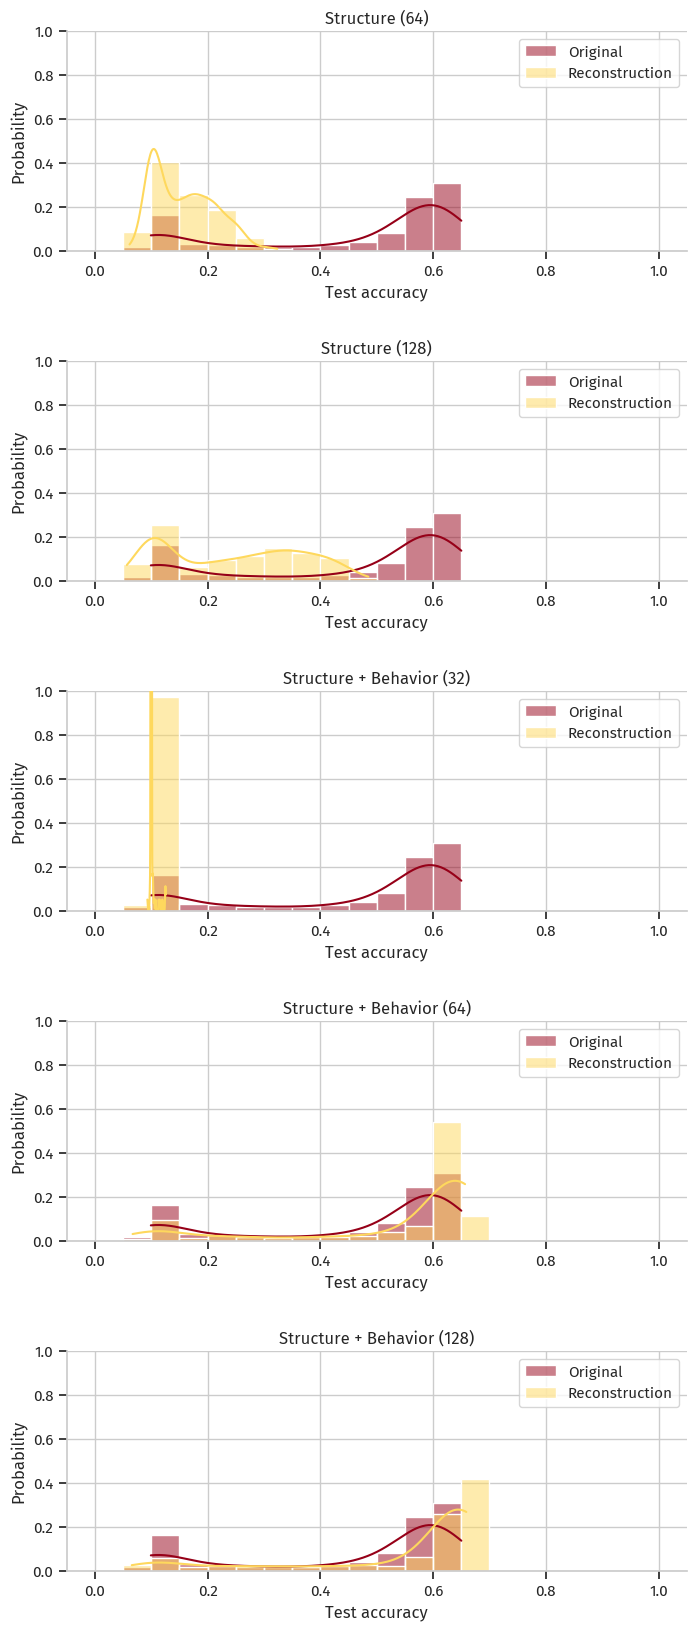

In [19]:
_, axs = plt.subplots(len(idx_dict), 1, figsize=(8, 4*len(idx_dict)))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i])
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i])
    axs[i].set(title=label, xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    axs[i].legend()
    
plt.subplots_adjust(hspace=0.5)
plt.show()

### Pairwise $L^2$ distance between weights

In [20]:
DF_ZOO_L2WEIGHTS_PATH = EXPERIMENT_PATH / 'df_zoo_l2weights.csv'

if not DF_ZOO_L2WEIGHTS_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_l2weights = pd.DataFrame(columns=['Hyper-representation model', 'L2 (structure)', 'MSE (structure)'])

    # Run experiments
    for data in tqdm(ZOO_DL):
        x, m, p, _ = data

        for hr_idx, hr_label in idx_dict.items():
            _, y, _ = hyper_reps[hr_idx].forward(x, p)
            
            for j in range(x.shape[0]):
                df_zoo_l2weights.loc[len(df_zoo_l2weights)] = (
                    hr_label,
                    torch.sqrt(torch.sum((x[j] - y[j]) ** 2)).item(),
                    torch.mean((x[j] - y[j]) ** 2).item()
                )
                
    # Save results
    df_zoo_l2weights.to_csv(DF_ZOO_L2WEIGHTS_PATH)
    
df_zoo_l2weights = pd.read_csv(DF_ZOO_L2WEIGHTS_PATH, index_col=0)
df_zoo_l2weights.head()

,Hyper-representation model,L2 (structure),MSE (structure)
0,Structure (64),44.768200,0.021991
1,Structure (64),31.388412,0.010811
2,Structure (64),30.944427,0.010507
3,Structure (64),33.579292,0.012372
4,Structure (64),21.822500,0.005225


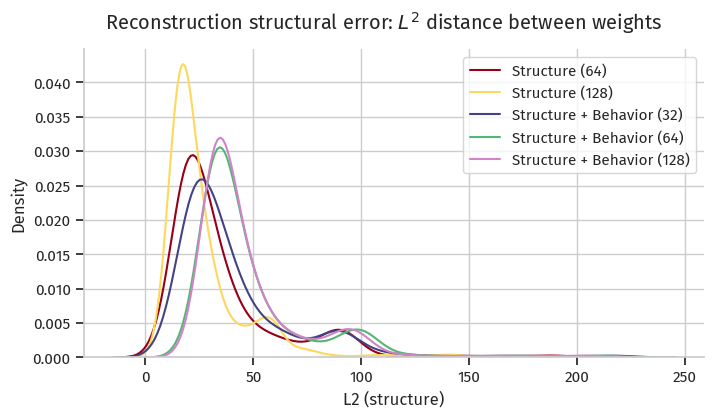

In [21]:
_, ax = plt.subplots(figsize=(8, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.kdeplot(df_zoo_l2weights[df_zoo_l2weights['Hyper-representation model'] == label], x='L2 (structure)', color=COLOURS[i], label=label, ax=ax)
    
plt.legend()
plt.suptitle('Reconstruction structural error: $L^2$ distance between weights')
plt.show()

### Pairwise $L^2$ distance between predictions

In [22]:
def reconstruct_model(hr, x, p, i):
    z, y, zp = hr.forward(x, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint)
    model = LeNet5(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

In [23]:
DF_ZOO_L2PREDS_PATH = EXPERIMENT_PATH / 'df_zoo_l2preds.csv'

if not DF_ZOO_L2PREDS_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_l2preds = pd.DataFrame(columns=['Hyper-representation model', 'L2 (behavior)', 'MSE (behavior)', 'Agreement'])

    # Run experiments
    for data in tqdm(ZOO_DL):
        x, m, p, _ = data

        for i in range(x.shape[0]):
            checkpoint = tokens_to_checkpoint(x[i], p[i], reference_checkpoint)
            orig_model = LeNet5(
                channels_in=reference_params['model::channels_in'],
                nlin=reference_params['model::nlin'],
                dropout=reference_params['model::dropout']
            )
            orig_model.load_state_dict(checkpoint)

            for hr_idx, hr_label in idx_dict.items():   
                recon_model = reconstruct_model(hyper_reps[hr_idx], x, p, i)
                
                l2_dist, mse, agreement = compare_models_prediction(orig_model, recon_model, TESTSET_DL, n_batches=None)
                
                df_zoo_l2preds.loc[len(df_zoo_l2preds)] = (
                    hr_label,
                    l2_dist,
                    mse,
                    agreement
                )
                    
                
    # Save results
    df_zoo_l2preds.to_csv(DF_ZOO_L2PREDS_PATH)
    
df_zoo_l2preds = pd.read_csv(DF_ZOO_L2PREDS_PATH, index_col=0)
df_zoo_l2preds.head()

,Hyper-representation model,L2 (behavior),MSE (behavior),Agreement
0,Structure (64),1.048509,0.110597,0.0028
1,Structure (128),1.010058,0.103201,0.0128
2,Structure + Behavior (32),0.313613,0.011802,0.0007
3,Structure + Behavior (64),0.283771,0.009510,0.1643
4,Structure + Behavior (128),0.292765,0.010104,0.1784


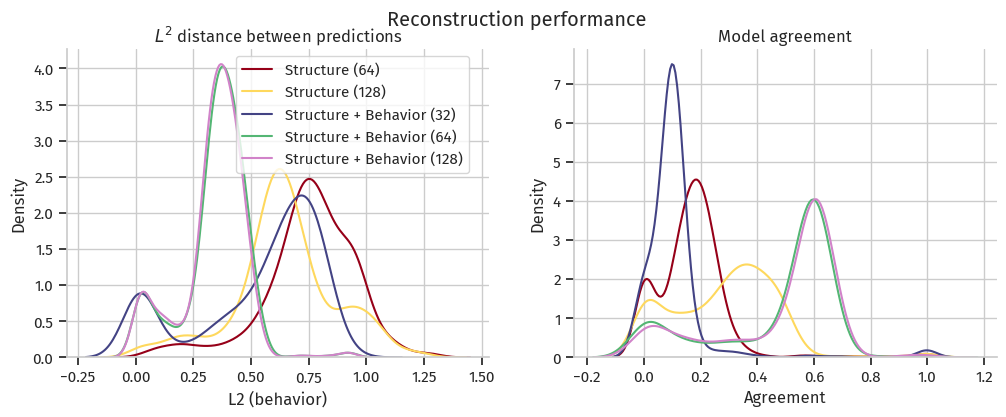

In [24]:
_, axs = plt.subplots(1 ,2, figsize=(12, 4))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.kdeplot(df_zoo_l2preds[df_zoo_l2preds['Hyper-representation model'] == label], x='L2 (behavior)', color=COLOURS[i], label=label, ax=axs[0])
    sns.kdeplot(df_zoo_l2preds[df_zoo_l2preds['Hyper-representation model'] == label], x='Agreement', color=COLOURS[i], label=label, ax=axs[1])
    
    
axs[0].set(title='$L^2$ distance between predictions')
axs[1].set(title='Model agreement')
    
plt.legend(loc=(-0.80, 0.60))
plt.suptitle('Reconstruction performance')
plt.show()

## Analysing generative downstream tasks

In [25]:
def compute_acc_from_z(hr, z, p, i, dataloader):
    z = z.type(next(hr.parameters()).dtype)

    y = hr.to(z.device).forward_decoder(z, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint_cuda)
    model = LeNet5(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return test_model(model, dataloader)

In [26]:
# Select only models with original accuracy above a threshold
good_models_ids = df_zoo_acc[df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR]['Model index'].unique().tolist()
df_z_good_models = df_z[df_z['Model index'].isin(good_models_ids)]

# Generate anchors and samples
z_anchors = {hr_label: df_z_good_models[df_z_good_models['Hyper-representation model'] == hr_label][Z_COLS].dropna(axis=1).values for hr_label in idx_dict.values()}
z_samples = {k: generate_z_samples(z) for k, z in z_anchors.items()}

# Print diagnostic statistics:
df_diagnostic = pd.DataFrame(columns=['Original std', 'Sampled std'])
for key in z_anchors.keys():
    df_diagnostic.loc[key] = (
        z_anchors[key].std(axis=0).mean(),
        z_samples[key].std(axis=0).mean()
    )
display(df_diagnostic)

# Reshape anchors and samples
z_anchors = {k: z.reshape((z.shape[0], Z_DIM_1, -1)) for k, z in z_anchors.items()}
z_samples = {k: z.reshape((z.shape[0], Z_DIM_1, -1)) for k, z in z_samples.items()}

del df_z_good_models, df_diagnostic

,Original std,Sampled std
Structure (64),0.175049,0.146720
Structure (128),0.125285,0.104442
Structure + Behavior (32),0.080966,0.066301
Structure + Behavior (64),0.018688,0.015270
Structure + Behavior (128),0.022064,0.018306


In [27]:
DF_GENERATIVE_PATH = EXPERIMENT_PATH / 'df_generative.csv'

if not DF_GENERATIVE_PATH.is_file() or RERUN:
    # Create dataframe
    df_generative = pd.DataFrame(columns=['Hyper-representation model', 'Origin', 'Accuracy'])
    
    p = next(iter(ZOO_DL))[2]

    for hr_idx, hr_label in tqdm(idx_dict.items(), unit='hyperrepresentation model'):
        z = torch.tensor(z_samples[hr_label]).to('cuda')
        p_z = p[0].repeat(z.shape[0], 1, 1).to('cuda') 
        
        for i in range(z.shape[0]):
            recon_acc = compute_acc_from_z(hyper_reps[hr_idx], z, p_z, i, TESTSET_DL)
            df_generative.loc[len(df_generative)] = (
                hr_label,
                'Generated',
                recon_acc
            )
                
    # Save results
    df_generative.to_csv(DF_GENERATIVE_PATH)
    
df_generative = pd.read_csv(DF_GENERATIVE_PATH, index_col=0)
df_generative.head()

,Hyper-representation model,Origin,Accuracy
0,Structure (64),Generated,0.1000
1,Structure (64),Generated,0.2070
2,Structure (64),Generated,0.2401
3,Structure (64),Generated,0.1988
4,Structure (64),Generated,0.2649


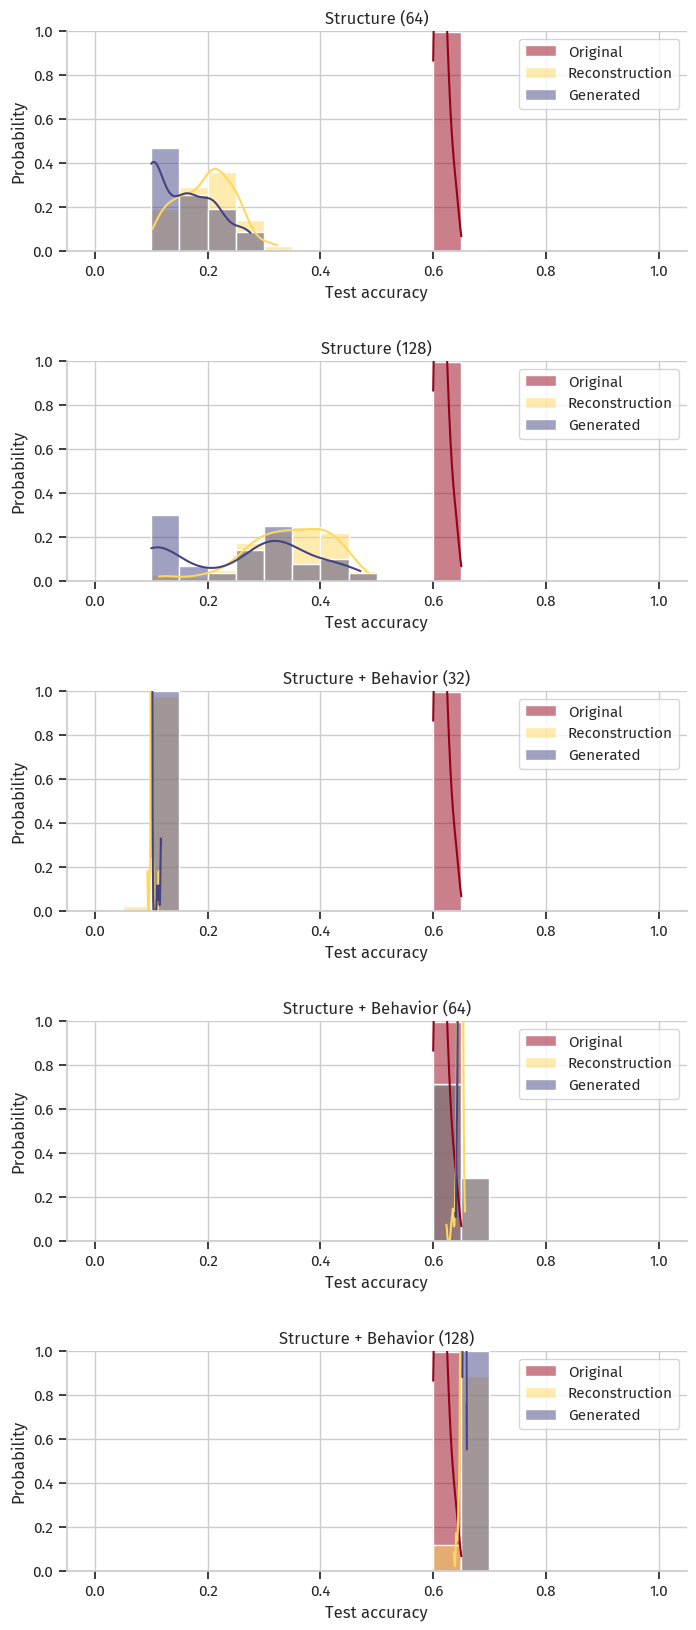

In [28]:
n_figures = len(df_generative['Hyper-representation model'].unique())

fig, axs = plt.subplots(n_figures, figsize=(8, 4*n_figures))

for i, (idx, label) in enumerate(idx_dict.items()):
    sns.histplot(df_zoo_acc[(df_zoo_acc['Hyper-representation model'] == label) & (df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR)], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i])
    sns.histplot(df_zoo_acc[(df_zoo_acc['Hyper-representation model'] == label) & (df_zoo_acc['Original accuracy'] >= MODEL_ACC_THR)], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i])
    sns.histplot(
        df_generative[(df_generative['Hyper-representation model'] == label) & (df_generative['Origin'] == 'Generated')],
        x='Accuracy',
        stat='probability',
        binwidth=0.05,
        binrange=(0., 1.),
        kde=True,
        color=COLOURS[2],
        alpha=0.5,
        label='Generated',
        ax=axs[i]
    )
    axs[i].set(title=label, xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    axs[i].legend()
    
plt.subplots_adjust(hspace=0.5)
plt.show()

### Verifying model diversity

In [29]:
def x_to_checkpoint(x, p, i):
    checkpoint = tokens_to_checkpoint(x[i], p[i], reference_checkpoint_cuda)
    model = LeNet5(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

def z_to_checkpoint(hr, z, p, i):
    z = z.type(next(hr.parameters()).dtype)

    y = hr.to(z.device).forward_decoder(z, p)
    checkpoint = tokens_to_checkpoint(y[i], p[i], reference_checkpoint_cuda)
    model = LeNet5(
        channels_in=reference_params['model::channels_in'],
        nlin=reference_params['model::nlin'],
        dropout=reference_params['model::dropout']
    )
    model.load_state_dict(checkpoint)
    
    return model

In [30]:
GEN_DIVERSITY_PATH = EXPERIMENT_PATH / 'gen_diversity.json'

if not GEN_DIVERSITY_PATH.is_file() or RERUN:
    gen_diversity = dict()
    
    p = next(iter(ZOO_DL))[2]
    
    # Original model zoo
    df_x_good_models = df_x[df_x['Model index'].isin(good_models_ids)]
    x = df_x_good_models[df_x_good_models['Hyper-representation model'] == list(idx_dict.values())[0]][X_COLS].values.reshape((-1, X_DIM_1, X_DIM_2))
    x = torch.tensor(x).to('cuda')
    p_x = p[0].repeat(x.shape[0], 1, 1).to('cuda')
    original_models = [x_to_checkpoint(x, p_x, i) for i in range(x.shape[0])]
    gen_diversity['Model zoo'] = dict()
    
    # L2 (weights)
    dist_mat = distance_matrix(original_models, metric='l2')
    distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
    gen_diversity['Model zoo']['l2_structure'] = distances.tolist()
    
    # L2 (predictions)
    dist_mat = distance_matrix(original_models, metric='l2_preds', testset='data', ds_test=TESTSET_DS)
    distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
    gen_diversity['Model zoo']['l2_behaviour'] = distances.tolist()
    
    del df_x_good_models, x, original_models

    for hr_idx, hr_label in tqdm(idx_dict.items(), unit='hyperrepresentation model'):        
        z = torch.tensor(z_samples[hr_label]).to('cuda')
        p_z = p[0].repeat(z.shape[0], 1, 1).to('cuda')
        generated_models = [z_to_checkpoint(hyper_reps[hr_idx], z, p_z, i) for i in range(z.shape[0])]
        gen_diversity[hr_label] = dict()
    
        # L2 (weights)
        dist_mat = distance_matrix(generated_models, metric='l2')
        distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
        gen_diversity[hr_label]['l2_structure'] = distances.tolist()

        # L2 (predictions)
        dist_mat = distance_matrix(generated_models, metric='l2_preds', testset='data', ds_test=TESTSET_DS)
        distances = dist_mat[np.triu_indices(dist_mat.shape[0], k=1)]
        gen_diversity[hr_label]['l2_behaviour'] = distances.tolist()
        
        del z, generated_models
                
    # Save results
    with open(GEN_DIVERSITY_PATH, 'w') as ofh:
        json.dump(gen_diversity, ofh)
    
with open(GEN_DIVERSITY_PATH, 'r') as ifh:
    gen_diversity = json.load(ifh)

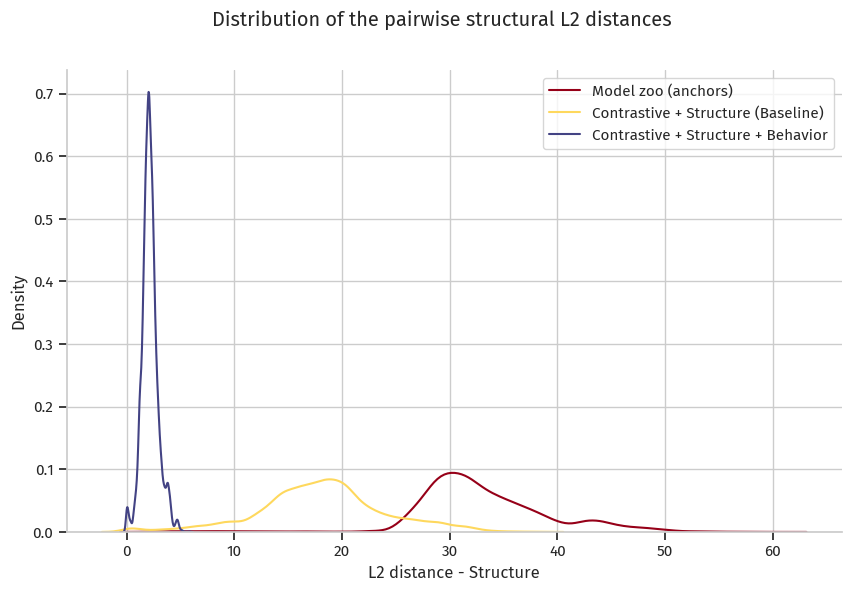

In [31]:
_, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(gen_diversity['Model zoo']['l2_structure'], color=COLOURS[0], label='Model zoo (anchors)', ax=ax)
sns.kdeplot(gen_diversity['Structure (64)']['l2_structure'], color=COLOURS[1], label='Contrastive + Structure (Baseline)', ax=ax)
sns.kdeplot(gen_diversity['Structure + Behavior (64)']['l2_structure'], color=COLOURS[2], label='Contrastive + Structure + Behavior', ax=ax)

ax.set(xlabel='L2 distance - Structure')

plt.legend()
plt.suptitle('Distribution of the pairwise structural L2 distances')
plt.show()

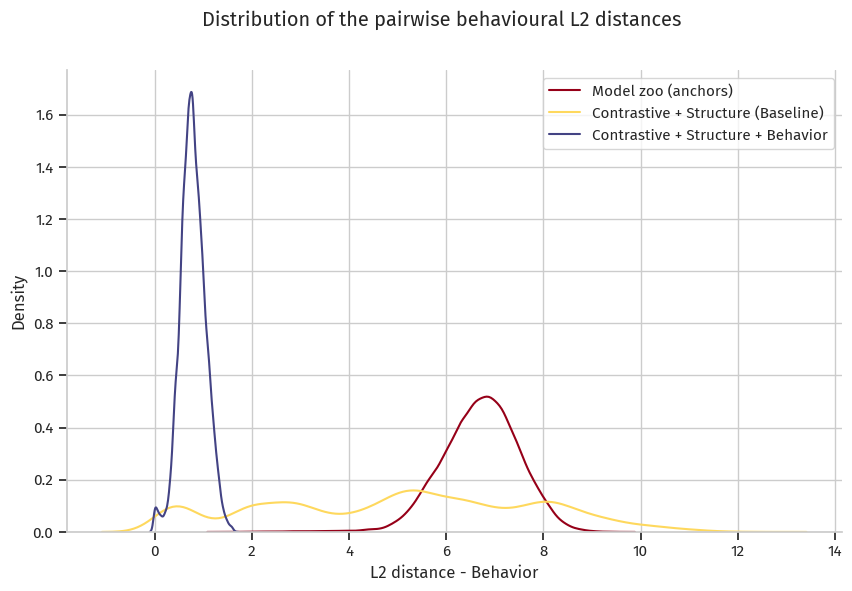

In [32]:
_, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(gen_diversity['Model zoo']['l2_behaviour'], color=COLOURS[0], label='Model zoo (anchors)', ax=ax)
sns.kdeplot(gen_diversity['Structure (64)']['l2_behaviour'], color=COLOURS[1], label='Contrastive + Structure (Baseline)', ax=ax)
sns.kdeplot(gen_diversity['Structure + Behavior (64)']['l2_behaviour'], color=COLOURS[2], label='Contrastive + Structure + Behavior', ax=ax)

ax.set(xlabel='L2 distance - Behavior')

plt.legend()
plt.suptitle('Distribution of the pairwise behavioural L2 distances')
plt.show()

## Figure for paper

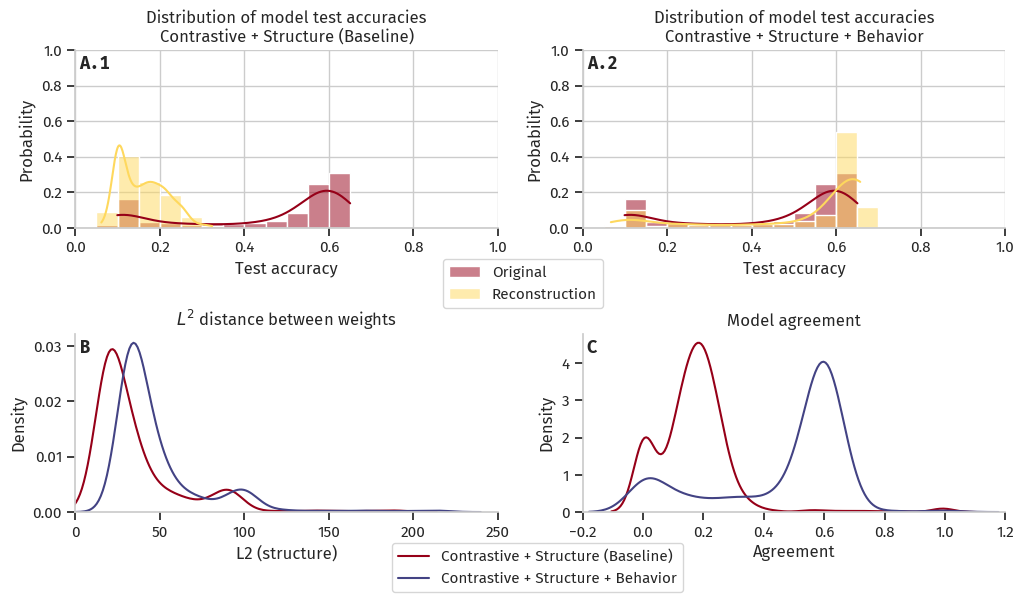

In [33]:
_, axs = plt.subplots(2, 2, figsize=(12, 6))

# Structure
label = 'Structure (64)'
sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[0][0])
sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[0][0])
axs[0][0].set(title="Distribution of model test accuracies\nContrastive + Structure (Baseline)", xlabel='Test accuracy', ylabel='Probability', xlim=(0, 1), ylim=(0, 1))
axs[0][0].legend(loc=(0.87, -0.45))
axs[0][0].text(0.01, 0.975, 'A.1', transform=axs[0][0].transAxes, fontfamily='Fira Code', fontsize=12, fontweight='bold', va='top', ha='left')

sns.kdeplot(df_zoo_l2weights[df_zoo_l2weights['Hyper-representation model'] == label], x='L2 (structure)', color=COLOURS[0], label="Contrastive + Structure (Baseline)", ax=axs[1][0])
sns.kdeplot(df_zoo_l2preds[df_zoo_l2preds['Hyper-representation model'] == label], x='Agreement', color=COLOURS[0], label="Contrastive + Structure (Baseline)", ax=axs[1][1])

# Structure + Behavior
label = 'Structure + Behavior (64)'
sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[0][1])
sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[0][1])
axs[0][1].set(title="Distribution of model test accuracies\nContrastive + Structure + Behavior", xlabel='Test accuracy', ylabel='Probability', xlim=(0, 1), ylim=(0, 1))
axs[0][1].text(0.01, 0.975, 'A.2', transform=axs[0][1].transAxes, fontfamily='Fira Code', fontsize=12, fontweight='bold', va='top', ha='left')

sns.kdeplot(df_zoo_l2weights[df_zoo_l2weights['Hyper-representation model'] == label], x='L2 (structure)', color=COLOURS[2], label="Contrastive + Structure + Behavior", ax=axs[1][0])
sns.kdeplot(df_zoo_l2preds[df_zoo_l2preds['Hyper-representation model'] == label], x='Agreement', color=COLOURS[2], label="Contrastive + Structure + Behavior", ax=axs[1][1])

# Label & legend
axs[1][0].set(title="$L^2$ distance between weights", xlim=(0,250))
axs[1][1].set(title="Model agreement", xlim=(-0.2, 1.2))
axs[1][0].legend(loc=(0.75, -0.45))
axs[1][0].text(0.01, 0.975, 'B', transform=axs[1][0].transAxes, fontfamily='Fira Code', fontsize=12, fontweight='bold', va='top', ha='left')
axs[1][1].text(0.01, 0.975, 'C', transform=axs[1][1].transAxes, fontfamily='Fira Code', fontsize=12, fontweight='bold', va='top', ha='left')

for ax in axs[1]:
    ax.grid(which='major', axis='x', visible=False)
    ax.grid(which='major', axis='y', visible=False)

plt.subplots_adjust(hspace=0.6)
plt.savefig('figures/cifar10_lenet5.png', dpi=300, bbox_inches='tight')
plt.show()